In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import mplhep as hep
import numpy as np

import ROOT

mpl.style.use(hep.style.ATLAS)

Welcome to JupyROOT 6.24/02


Generazione di A, B, generazione di gaussiane come A, B 

A = 1.729811(322)
B = 1.34626(580)e-14


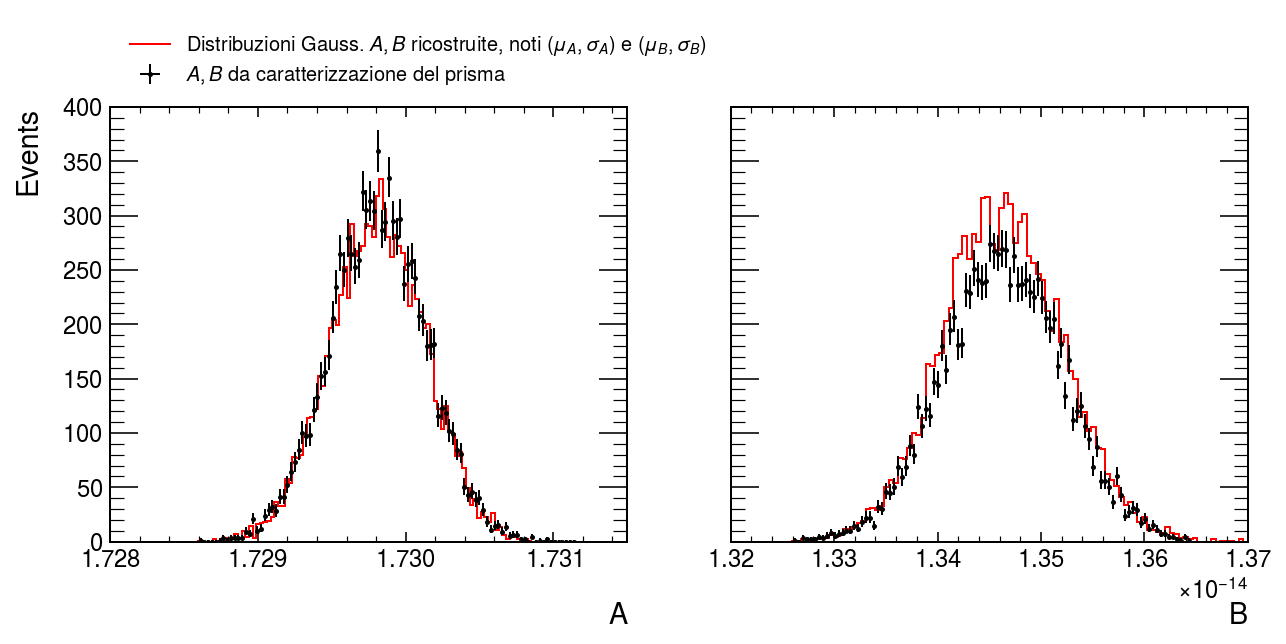

In [2]:
α = np.pi/3
λ_1 = 579.1e-9 ## [nm] Y
λ_2 = 404.7e-9 ## [nm] P
θ_0 = 1.5701
θ_1 = 2.6958
θ_2 = 2.7904

θ_m3 = 2.6773
θ_m4 = 2.7324
θ_m5 = 2.7651
θ_m6 = 2.7846

Δ_θ = 0.0005

σ_θ = Δ_θ/np.sqrt(3)

def computeAB(th_0, th_1, th_2):
    
    def n_i(th_i, th_0):
        return np.sin((th_i - th_0 + α)/2)/np.sin(α/2)
    A = (n_i(th_1, th_0)*λ_1**2 - n_i(th_2, th_0)*λ_2**2)/(λ_1**2 - λ_2**2)
    B = (n_i(th_1, th_0) - n_i(th_2, th_0))/(1/(λ_1**2) - 1/(λ_2**2))
    return A, B

n_samples = 10_000

rnd = ROOT.TRandom3(58347942)

h_AB = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)

for _ in range(n_samples):
    A, B = computeAB(th_0=rnd.Gaus(θ_0,σ_θ), th_1=rnd.Gaus(θ_1,σ_θ), th_2=rnd.Gaus(θ_2,σ_θ))
    h_AB.Fill(A, B)
    
ρ = h_AB.GetCorrelationFactor()

from uncertainties import ufloat
print(f'A = {ufloat(h_AB.ProjectionX().GetMean(), h_AB.ProjectionX().GetStdDev()):.3uS}')
μ_A, σ_A = h_AB.ProjectionX().GetMean(), h_AB.ProjectionX().GetStdDev()
print(f'B = {ufloat(h_AB.ProjectionY().GetMean(), h_AB.ProjectionY().GetStdDev()):.3uS}')
μ_B, σ_B = h_AB.ProjectionY().GetMean(), h_AB.ProjectionY().GetStdDev()


h_A_gaus = ROOT.TH1D('', '', 100, 0, 0)
h_B_gaus = ROOT.TH1D('', '', 100, 0, 0)

for _ in range(n_samples):
    h_A_gaus.Fill(rnd.Gaus(μ_A, σ_A))
    h_B_gaus.Fill(rnd.Gaus(μ_B, σ_B))


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3.75), sharey=True)

hep.histplot(h_AB.ProjectionX(), ax=ax1, histtype='errorbar', color='k', markersize=3)
hep.histplot(h_A_gaus, yerr=False, ax=ax1, color='r')
hep.histplot(h_AB.ProjectionY(), ax=ax2, histtype='errorbar', color='k', \
             label=r'$A,B$ da caratterizzazione del prisma', markersize=3)
hep.histplot(h_B_gaus, yerr=False, ax=ax2, color='r', label=r'Distribuzioni Gauss. $A,B$ ricostruite, noti $(\mu_A,\sigma_A)$ e $(\mu_B, \sigma_B)$')

ax2.legend(loc=(-1.2,1.))
ax1.set_xlabel('A', labelpad=15)
ax1.set_ylabel('Events')
ax2.set_xlabel('B', labelpad=15)

fig.savefig('gaus_compAB.pdf',bbox_inches='tight')


In [3]:
def over_λ(θ, θ_0, α, A, B):
    return ((np.sin((θ - θ_0 + α)/2)/np.sin(α/2) - A)/B)**0.5

def getRH(overλ, m, n=2):
    def balmer(m = m, n=n):
        return 1/n**2 - 1/m**2
    return overλ/balmer(m,n)

def genAB(rnd = rnd):
    B = rnd.Gaus(μ_B, σ_B)
    A =ρ*σ_A/σ_B*B + σ_A*np.sqrt(1-ρ**2)*rnd.Gaus((μ_A/σ_A - ρ*μ_B/σ_B)/np.sqrt(1-ρ**2))
    return A, B

θ = np.array([θ_m3, θ_m4, θ_m5, θ_m6])

n = 2, m = 3: R_H = 1.10056(502)e+07
n = 2, m = 4: R_H = 1.09637(236)e+07
n = 2, m = 5: R_H = 1.09623(183)e+07
n = 2, m = 6: R_H = 1.09516(166)e+07


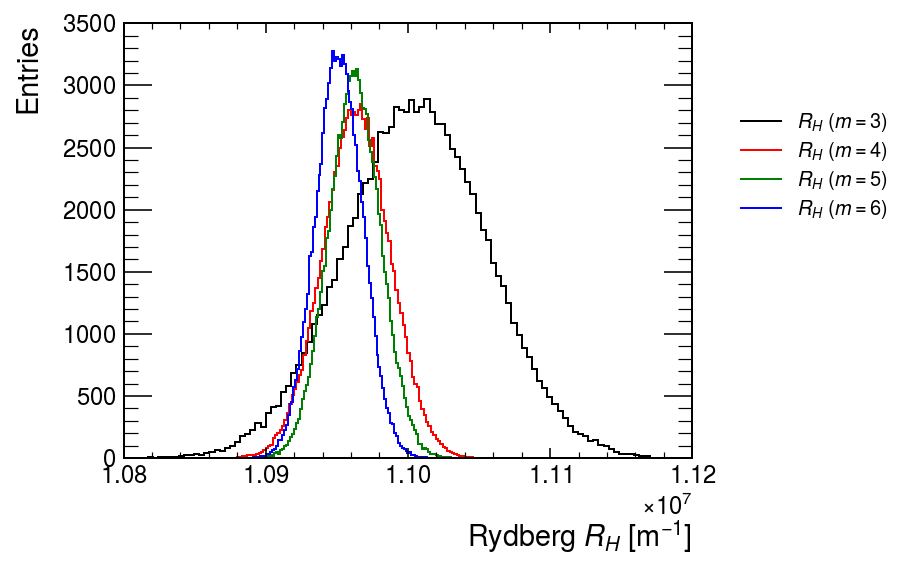

In [4]:
n_samples = 100_000

rnd = ROOT.TRandom3(320358902)

h_RH_3 = ROOT.TH1D('', '', 100, 0, 0)
h_RH_4 = ROOT.TH1D('', '', 100, 0, 0)
h_RH_5 = ROOT.TH1D('', '', 100, 0, 0)
h_RH_6 = ROOT.TH1D('', '', 100, 0, 0)

h_RH_34 = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)


arr_RH_3 = np.zeros(n_samples)
arr_RH_4 = np.zeros(n_samples)
arr_RH_5 = np.zeros(n_samples)
arr_RH_6 = np.zeros(n_samples)

for i in range(n_samples):
    for m, rh, θ_m, arr_RH in zip(range(3,7), [h_RH_3, h_RH_4, h_RH_5, h_RH_6], θ, [arr_RH_3, arr_RH_4, arr_RH_5, arr_RH_6]):
        A, B = genAB()
        tmp = getRH(over_λ(rnd.Gaus(θ_m, σ_θ), rnd.Gaus(θ_0, σ_θ), α, A, B), m)
        rh.Fill(tmp)
        arr_RH[i] = tmp

fig, ax = plt.subplots(figsize=(5,3.75))
for m, rh, c in zip(range(3,7), [h_RH_3, h_RH_4, h_RH_5, h_RH_6], ['k','r','g','b']):
    hep.histplot(rh, color=c, yerr=False, label=f'$R_H$ ($m={m}$)', ax=ax)
ax.legend(loc=(1.05, 0.5))
ax.set_xlabel('Rydberg $R_H$ [m$^{-1}$]', labelpad=15)
ax.set_ylabel('Entries')

fig.savefig('rydberg.pdf', bbox_inches='tight')

for i, rh in enumerate([h_RH_3, h_RH_4, h_RH_5, h_RH_6]):
    print(f'n = 2, m = {i+3}: R_H = {ufloat(rh.GetMean(), rh.GetStdDev()):.3uS}')

In [5]:
V_RH_m = np.cov([arr_RH_3, arr_RH_4, arr_RH_5, arr_RH_6])
V_RH_m_inv = np.linalg.inv(V_RH_m)
ρ_RH_m = np.corrcoef([arr_RH_3, arr_RH_4, arr_RH_5, arr_RH_6])

μ_RH_m = np.array([rh.GetMean() for rh in [h_RH_3, h_RH_4, h_RH_5, h_RH_6]])
σ_RH_m = np.array([rh.GetStdDev() for rh in [h_RH_3, h_RH_4, h_RH_5, h_RH_6]])

μ_RH_m, σ_RH_m

(array([11005565.05965623, 10963728.68207135, 10962282.66950332,
        10951583.99485305]),
 array([50207.00438466, 23558.73699527, 18328.05054333, 16610.64440916]))

In [6]:


ρ_RH_m

array([[ 1.00000000e+00,  6.75568718e-03, -6.38625717e-03,
        -1.11547550e-03],
       [ 6.75568718e-03,  1.00000000e+00, -1.44406645e-03,
        -9.26123468e-04],
       [-6.38625717e-03, -1.44406645e-03,  1.00000000e+00,
         2.12199824e-03],
       [-1.11547550e-03, -9.26123468e-04,  2.12199824e-03,
         1.00000000e+00]])

In [7]:
def fcn(R_H):
    fcn = 0.0
    for i, RH_i in enumerate(μ_RH_m):
        for j, RH_j in enumerate(μ_RH_m):
            fcn += (RH_i - R_H) * V_RH_m_inv[i,j] * (RH_j - R_H)
    return fcn

In [8]:
import iminuit
from iminuit import cost, Minuit

In [9]:
m1 = Minuit(fcn, R_H=10e7)
m1.migrad()
m1.minos()

<ipython-input-9-3b8d7b2b4b4c>:2: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m1.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.115                      │              Nfcn = 24               │
│ EDM = 8.27e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R_H  │ 10.960e6  │  0.011e6  │  -0.011e6  │  0.011e6   │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┐
│          │          R_H          │
├──────────┼───────────┬───────────┤
│  Error   │ -0.011e6  │  0.011e6  │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘
┌─────┬──────────┐
│     │      R_H │
├─────┼──────────┤
│ R_H │ 1.14e+08 │
└─────┴──────────┘

In [10]:
μ_RH = m1.values['R_H']
σ_RH = m1.errors['R_H']



In [11]:
print(f'{ufloat(μ_RH, σ_RH):.3uS}')

1.09601(107)e+07


In [12]:
μ_RH_gls_lag = np.matmul(np.matmul(np.ones(4), V_RH_m_inv), μ_RH_m)/np.matmul(np.matmul(np.ones(4), V_RH_m_inv), np.ones(4))
σ_RH_gls_lag = 1/np.matmul(np.matmul(np.ones(4), V_RH_m_inv), np.ones(4))

In [13]:
print(f'{ufloat(μ_RH_gls_lag, σ_RH_gls_lag):.3uS}')

0.11(1.14)e+08
